# Inception model explanations, t3

## First we need dataframes for every subject

In [2]:
import sys
sys.path.append('../')
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import utils
import keras

%matplotlib inline

# DEFINE GRAPH
from importlib import reload
reload(utils)

pd.set_option('max_colwidth', 800) 

Using TensorFlow backend.


In [4]:
# Data paths
rgb_path = '../data/jpg_320_180_2fps/'
of_path = 'no'

# Hyperparameters
input_width = 320
input_height = 180
seq_length = 10
seq_stride = 1
batch_size = 10
COLOR = True
nb_labels = 2

# Data augmentation
aug_flip = 0
aug_crop = 0
aug_light = 0

nb_input_dims = 4

subject_ids = pd.read_csv('../metadata/horse_subjects.csv')['Subject'].values
channels = 3

In [5]:
from utils import ArgsProxy
args = ArgsProxy(rgb_path, of_path, input_height, input_width,
                 seq_length, seq_stride, batch_size, nb_labels,
                 aug_flip, aug_crop, aug_light, nb_input_dims)

In [6]:
import data_handler as dathand
dh = dathand.DataHandler(path=args.data_path,
                         of_path=args.of_path,
                         clip_list_file='videos_overview_missingremoved.csv',
                         data_columns=['Pain'],  # Here one can append f. ex. 'Observer'
                         image_size=(args.input_height, args.input_width),
                         seq_length=args.seq_length,
                         seq_stride=args.seq_stride,
                         batch_size=args.batch_size,
                         color=COLOR,
                         nb_labels=args.nb_labels,
                         aug_flip=args.aug_flip,
                         aug_crop=args.aug_crop,
                         aug_light=args.aug_light,
                         nb_input_dims=args.nb_input_dims)

In [7]:
import utils
subject_dfs = utils.read_or_create_subject_dfs(dh, args, subject_ids)

../data/jpg_320_180_2fps/
../data/jpg_320_180_2fps/
../data/jpg_320_180_2fps/
../data/jpg_320_180_2fps/
../data/jpg_320_180_2fps/
../data/jpg_320_180_2fps/


## Now that we have frames from all subjects, we can load the model we want to test.

In [8]:
# Choose a model to work on
best_model_path = '../models/BEST_MODEL_inception_4d_input_from_scratch_rmsprop_LSTMunits_None_CONVfilters_None_dense512_320x180jpg2fps_bs100_rmsprop_all_aug_v4_t3_run1_gc_rerun.h5'


In [9]:
from keras import backend as K
import tensorflow as tf

tf.reset_default_graph()
K.clear_session()
    
images = tf.placeholder(tf.float32, [batch_size, args.input_width, args.input_height, channels])
labels = tf.placeholder(tf.float32, [batch_size, 2])

model = utils.InceptionNetwork(images, from_scratch=0, path=best_model_path)

Loading model...
Finished loading model. Building layers...


In [10]:
sess = K.get_session()  # Grab the Keras session where the weights are initialized.

print('model preds: ', model.preds)

cost = (-1) * tf.reduce_sum(tf.multiply(labels, tf.log(model.preds)), axis=1)

print('cost: ', cost)

y_c = tf.reduce_sum(tf.multiply(model.dense_2, labels), axis=1)

print('y_c: ', y_c)


# target_conv_layer = model.c_86  # Choose which layer to study
target_conv_layer = model.c_94  # Here: last conv.
# target_conv_layer = model.mixed10 

print('TYPE tcl: ', type(target_conv_layer))
print('tcl: ', target_conv_layer)

target_conv_layer_grad = tf.gradients(y_c, target_conv_layer)[0]

print('tcl grad: ', target_conv_layer_grad)
print('tclg: ', target_conv_layer_grad)
    
gb_grad = tf.gradients(cost, images)[0]  # Guided backpropagation back to input layer

model preds:  Tensor("activation_95_1/Sigmoid:0", shape=(10, 2), dtype=float32)
cost:  Tensor("mul_1:0", shape=(10,), dtype=float32)
y_c:  Tensor("Sum_1:0", shape=(10,), dtype=float32)
TYPE tcl:  <class 'tensorflow.python.framework.ops.Tensor'>
tcl:  Tensor("conv2d_94_1/convolution:0", shape=(10, 8, 4, 192), dtype=float32)
tcl grad:  Tensor("gradients/AddN:0", shape=(10, 8, 4, 192), dtype=float32)
tclg:  Tensor("gradients/AddN:0", shape=(10, 8, 4, 192), dtype=float32)


In [11]:
def run_on_one_sequence(sess, model, batch_img, args):
    with sess.as_default():
        prob = sess.run(model.preds,
                        feed_dict={images: batch_img,
                                   K.learning_phase(): 0})

        print(prob)
        
        gb_grad_value, target_conv_layer_value, target_conv_layer_grad_value = sess.run([gb_grad, target_conv_layer, target_conv_layer_grad],
              feed_dict={images: batch_img,
              labels: batch_label,
              K.learning_phase(): 0})

#         print('tcl: ')
#         print(target_conv_layer_value)
#         print('')
#         print('tclg: ')
#         print(target_conv_layer_grad_value)
        
        utils.visualize_overlays(batch_img, target_conv_layer_value,
                                 target_conv_layer_grad_value, args)

# Inception predictions for subject t3

Chose subject  3
Start index in subject dataframe:  3145
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_4/4_1b/frame_001116.jpg     0
1  data/jpg_320_180_2fps/horse_4/4_1b/frame_001117.jpg     0
2  data/jpg_320_180_2fps/horse_4/4_1b/frame_001118.jpg     0
3  data/jpg_320_180_2fps/horse_4/4_1b/frame_001119.jpg     0
4  data/jpg_320_180_2fps/horse_4/4_1b/frame_001120.jpg     0
5  data/jpg_320_180_2fps/horse_4/4_1b/frame_001121.jpg     0
6  data/jpg_320_180_2fps/horse_4/4_1b/frame_001122.jpg     0
7  data/jpg_320_180_2fps/horse_4/4_1b/frame_001123.jpg     0
8  data/jpg_320_180_2fps/horse_4/4_1b/frame_001124.jpg     0
9  data/jpg_320_180_2fps/horse_4/4_1b/frame_001125.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


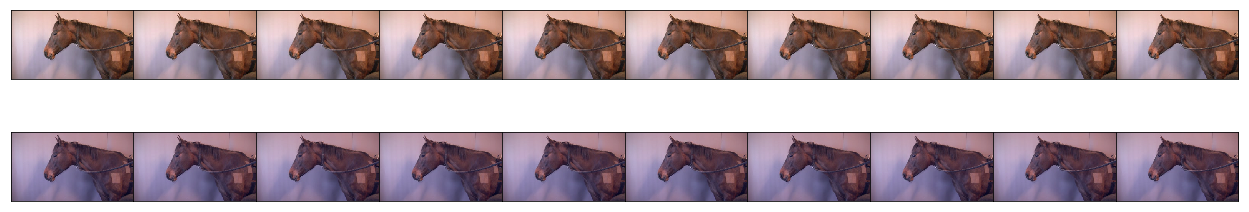

In [12]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=3)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  3
Start index in subject dataframe:  856
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_4/4_1a/frame_000857.jpg     0
1  data/jpg_320_180_2fps/horse_4/4_1a/frame_000858.jpg     0
2  data/jpg_320_180_2fps/horse_4/4_1a/frame_000859.jpg     0
3  data/jpg_320_180_2fps/horse_4/4_1a/frame_000860.jpg     0
4  data/jpg_320_180_2fps/horse_4/4_1a/frame_000861.jpg     0
5  data/jpg_320_180_2fps/horse_4/4_1a/frame_000862.jpg     0
6  data/jpg_320_180_2fps/horse_4/4_1a/frame_000863.jpg     0
7  data/jpg_320_180_2fps/horse_4/4_1a/frame_000864.jpg     0
8  data/jpg_320_180_2fps/horse_4/4_1a/frame_000865.jpg     0
9  data/jpg_320_180_2fps/horse_4/4_1a/frame_000866.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


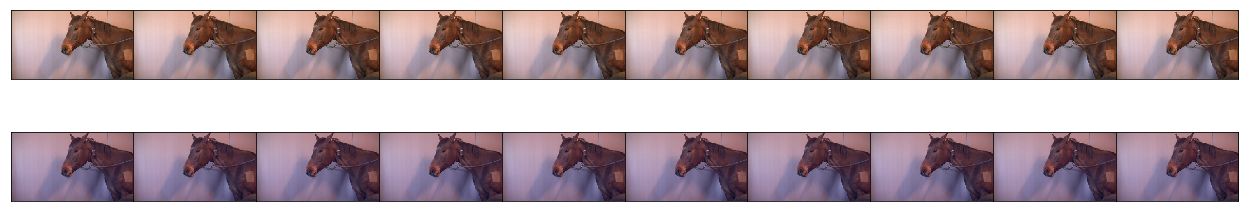

In [13]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=3)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  3
Start index in subject dataframe:  9539
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_4/4_2b/frame_000222.jpg     0
1  data/jpg_320_180_2fps/horse_4/4_2b/frame_000223.jpg     0
2  data/jpg_320_180_2fps/horse_4/4_2b/frame_000224.jpg     0
3  data/jpg_320_180_2fps/horse_4/4_2b/frame_000225.jpg     0
4  data/jpg_320_180_2fps/horse_4/4_2b/frame_000226.jpg     0
5  data/jpg_320_180_2fps/horse_4/4_2b/frame_000227.jpg     0
6  data/jpg_320_180_2fps/horse_4/4_2b/frame_000228.jpg     0
7  data/jpg_320_180_2fps/horse_4/4_2b/frame_000229.jpg     0
8  data/jpg_320_180_2fps/horse_4/4_2b/frame_000230.jpg     0
9  data/jpg_320_180_2fps/horse_4/4_2b/frame_000231.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


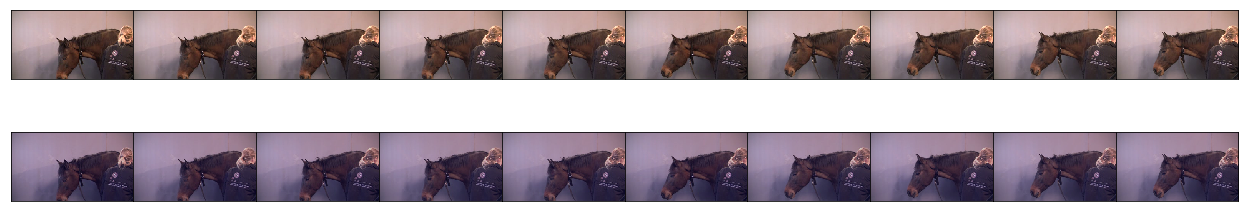

In [14]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=3)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  3
Start index in subject dataframe:  8933
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_4/4_2a/frame_001638.jpg     0
1  data/jpg_320_180_2fps/horse_4/4_2a/frame_001639.jpg     0
2  data/jpg_320_180_2fps/horse_4/4_2a/frame_001640.jpg     0
3  data/jpg_320_180_2fps/horse_4/4_2a/frame_001641.jpg     0
4  data/jpg_320_180_2fps/horse_4/4_2a/frame_001642.jpg     0
5  data/jpg_320_180_2fps/horse_4/4_2a/frame_001643.jpg     0
6  data/jpg_320_180_2fps/horse_4/4_2a/frame_001644.jpg     0
7  data/jpg_320_180_2fps/horse_4/4_2a/frame_001645.jpg     0
8  data/jpg_320_180_2fps/horse_4/4_2a/frame_001646.jpg     0
9  data/jpg_320_180_2fps/horse_4/4_2a/frame_001647.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


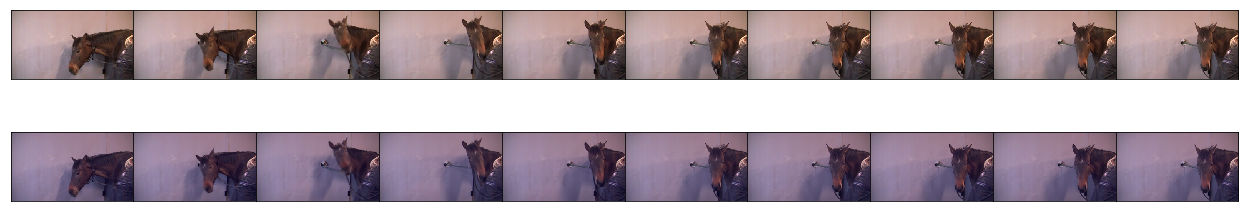

In [15]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=3)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  3
Start index in subject dataframe:  8683
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_4/4_2a/frame_001388.jpg     0
1  data/jpg_320_180_2fps/horse_4/4_2a/frame_001389.jpg     0
2  data/jpg_320_180_2fps/horse_4/4_2a/frame_001390.jpg     0
3  data/jpg_320_180_2fps/horse_4/4_2a/frame_001391.jpg     0
4  data/jpg_320_180_2fps/horse_4/4_2a/frame_001392.jpg     0
5  data/jpg_320_180_2fps/horse_4/4_2a/frame_001393.jpg     0
6  data/jpg_320_180_2fps/horse_4/4_2a/frame_001394.jpg     0
7  data/jpg_320_180_2fps/horse_4/4_2a/frame_001395.jpg     0
8  data/jpg_320_180_2fps/horse_4/4_2a/frame_001396.jpg     0
9  data/jpg_320_180_2fps/horse_4/4_2a/frame_001397.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


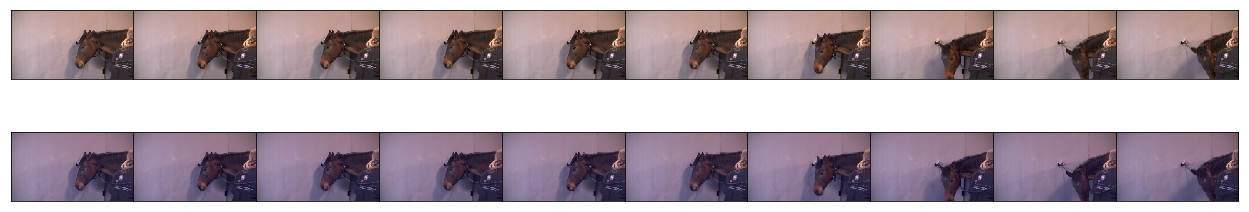

In [16]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=3)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  3
Start index in subject dataframe:  8986
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_4/4_2a/frame_001691.jpg     0
1  data/jpg_320_180_2fps/horse_4/4_2a/frame_001692.jpg     0
2  data/jpg_320_180_2fps/horse_4/4_2a/frame_001693.jpg     0
3  data/jpg_320_180_2fps/horse_4/4_2a/frame_001694.jpg     0
4  data/jpg_320_180_2fps/horse_4/4_2a/frame_001695.jpg     0
5  data/jpg_320_180_2fps/horse_4/4_2a/frame_001696.jpg     0
6  data/jpg_320_180_2fps/horse_4/4_2a/frame_001697.jpg     0
7  data/jpg_320_180_2fps/horse_4/4_2a/frame_001698.jpg     0
8  data/jpg_320_180_2fps/horse_4/4_2a/frame_001699.jpg     0
9  data/jpg_320_180_2fps/horse_4/4_2a/frame_001700.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


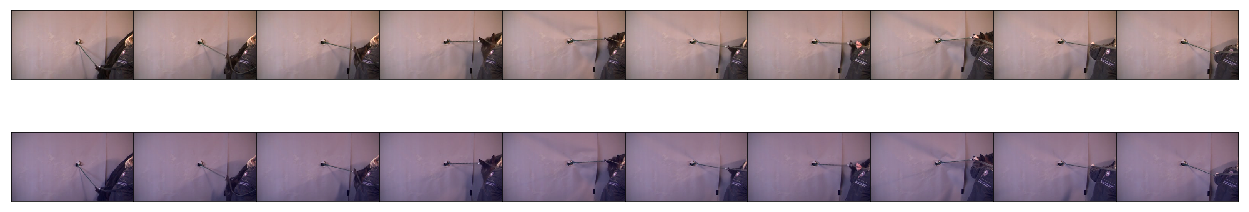

In [17]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=3)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)